In [20]:
# !pip install tensorflow
# !pip install plot_keras_history

In [21]:
import mlflow
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from plot_keras_history import show_history

from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import ModelCheckpoint
import h5py

In [22]:
mlflow.set_experiment("BDL Assignment 5")

2024/04/21 14:55:24 INFO mlflow.tracking.fluent: Experiment with name 'BDL Assignment 5' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/sem%208/CS5830/Assignment%205/mlruns/724536142507697262', creation_time=1713691524826, experiment_id='724536142507697262', last_update_time=1713691524826, lifecycle_stage='active', name='BDL Assignment 5', tags={}>

In [23]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
num_classes = 10
x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape, 'train input samples')
print(x_test.shape, 'test input samples')

(60000, 784) train input samples
(10000, 784) test input samples


In [24]:
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)
print(y_train.shape, 'train output samples')
print(y_test.shape, 'test output samples')

(60000, 10) train output samples
(10000, 10) test output samples


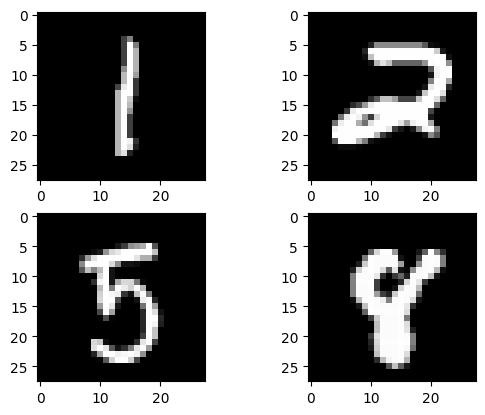

In [25]:
plt.subplot(221)
plt.imshow(X_train[310], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[515], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[1210], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[2150], cmap=plt.get_cmap('gray'))
plt.show()

In [26]:
def build_basic_nn(params):
    mlp = Sequential([
        Dense(params["layer1_size"], activation=params['activation'], kernel_regularizer=params['regularizers'], input_shape=(784,)),
        Dropout(params["dropout_rate_l1"]),
        Dense(params["layer2_size"], activation=params['activation'], kernel_regularizer=params['regularizers']),
        Dropout(params["dropout_rate_l2"]),
        Dense(params["output_size"], activation='softmax')
    ])
    return mlp

def train_mlp(mlp, train_params, x_train, y_train):

    if train_params["use_optimiser"] == True:
        opt_new = keras.optimizers.SGD(learning_rate=train_params["learning_rate"], momentum=train_params["momentum"])
        mlp.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt_new)
    else:
        mlp.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    
    
    if train_params["early_stopping"] == True:
        checkpoint = ModelCheckpoint(r"mnist-epoch-{epoch:02d}.keras")
        history = mlp.fit(x_train, y_train, epochs=train_params["num_epochs"], validation_data=(x_test, y_test), callbacks=[checkpoint])
        es = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2)
        mlp.fit(x_train, y_train, epochs=train_params["num_epochs"], validation_data=(x_test, y_test), callbacks=[es], batch_size=train_params["batch_size"])
    else:
        history = mlp.fit(x_train, y_train, epochs=train_params["num_epochs"], validation_data=(x_test, y_test), batch_size=train_params["batch_size"])
        
    show_history(history)
    
    return mlp


def mlp_mlflow_run(
    name,
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
):
    with mlflow.start_run(run_name=name):
        mlflow.log_params(mlp_params)
        mlflow.log_params(train_params)
        mlflow.set_tag("model_name", "MLP")

        model = build_basic_nn(mlp_params)
        model = train_mlp(model, train_params, x_train, y_train)

        loss, acc = model.evaluate(x_train, y_train, verbose=2)
        print("Train accuracy: {:5.2f}%".format(100*acc))

        mlflow.log_metric("Train Loss", loss)
        mlflow.log_metric("Train Accuracy", acc)

        loss, acc = model.evaluate(x_test, y_test, verbose=2)
        print("Test accuracy: {:5.2f}%".format(100*acc))

        mlflow.log_metric("Test Loss", loss)
        mlflow.log_metric("Test Accuracy", acc)
        
        mlflow.tensorflow.log_model(model, "Basic Neural Network")

        test_pt = 782
        plt.imshow(X_test[test_pt], cmap=plt.get_cmap('gray'))
        probs = model.predict(x_test[test_pt:test_pt+1], verbose=True)
        print("Predicted Digit:", np.argmax(probs))
        plt.title('Predicted Image')
        plt.savefig("Predicted_Image.png")
        mlflow.log_artifact("Predicted_Image.png")
        plt.show()

## Basic Neural Network

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5988 - loss: 1.5340 - val_accuracy: 0.8856 - val_loss: 0.4630
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8880 - loss: 0.4224 - val_accuracy: 0.9167 - val_loss: 0.3060
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9166 - loss: 0.3023 - val_accuracy: 0.9300 - val_loss: 0.2501
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9328 - loss: 0.2400 - val_accuracy: 0.9379 - val_loss: 0.2151
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9411 - loss: 0.2068 - val_accuracy: 0.9445 - val_loss: 0.1942
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9470 - loss: 0.1862 - val_accuracy: 0.9462 - val_loss: 0.1818
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9513 - loss: 0.1712 - val_accuracy: 0.9475 - val_loss: 0.1759
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9525 - loss: 0.1618 - 

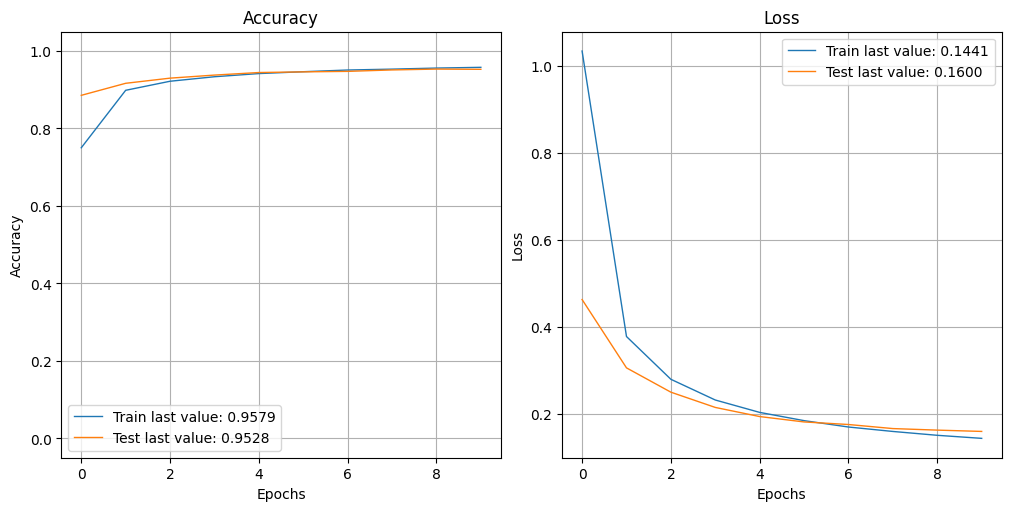

1875/1875 - 2s - 1ms/step - accuracy: 0.9612 - loss: 0.1338
Train accuracy: 96.12%
313/313 - 0s - 1ms/step - accuracy: 0.9528 - loss: 0.1600


2024/04/21 14:55:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 95.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Digit: 3


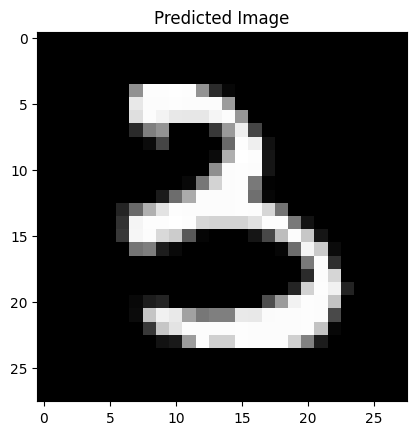

In [27]:
mlp_params = {
    "layer1_size": 20,
    "dropout_rate_l1": 0,
    "layer2_size": 20,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=False,
    learning_rate=0.1,
    momentum=0.0,
    num_epochs=10,
    early_stopping= False,
    batch_size=32,  
)

mlp_mlflow_run(
    "mlp_base",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

____________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________

## Bigger Neural Network

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8041 - loss: 0.7051 - val_accuracy: 0.9365 - val_loss: 0.2056
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9425 - loss: 0.1878 - val_accuracy: 0.9538 - val_loss: 0.1490
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9596 - loss: 0.1315 - val_accuracy: 0.9635 - val_loss: 0.1129
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9716 - loss: 0.0912 - val_accuracy: 0.9699 - val_loss: 0.0992
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9772 - loss: 0.0741 - val_accuracy: 0.9715 - val_loss: 0.0953
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9809 - loss: 0.0619 - val_accuracy: 0.9763 - val_loss: 0.0758
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9852 - loss: 0.0484 - val_accuracy: 0.9762 - val_loss: 0.0764
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9874 - loss: 0.0433 - 

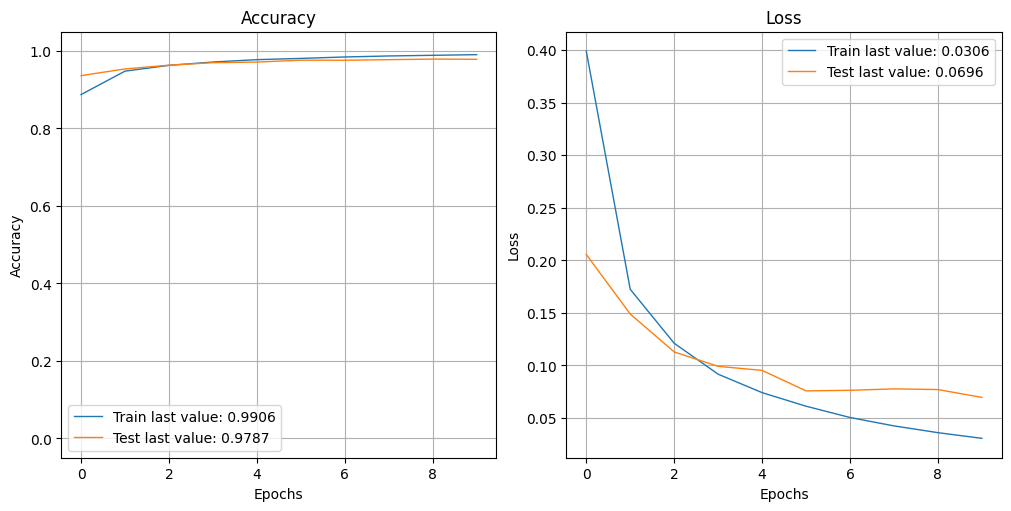

1875/1875 - 3s - 1ms/step - accuracy: 0.9936 - loss: 0.0229
Train accuracy: 99.36%
313/313 - 0s - 1ms/step - accuracy: 0.9787 - loss: 0.0696


2024/04/21 14:57:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 97.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Digit: 3


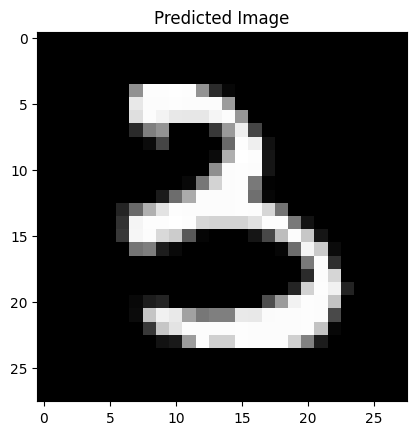

In [28]:
mlp_params = {
    "layer1_size": 256,
    "dropout_rate_l1": 0,
    "layer2_size": 128,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=False,
    learning_rate=0.1,
    momentum=0.0, 
    num_epochs=10,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_big_network",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

____________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________

## Adding kernel regularization to the mix.

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5533 - loss: 2.3456 - val_accuracy: 0.7444 - val_loss: 1.3933
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7437 - loss: 1.3789 - val_accuracy: 0.8025 - val_loss: 1.2051
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7781 - loss: 1.2417 - val_accuracy: 0.7900 - val_loss: 1.1756
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7843 - loss: 1.1795 - val_accuracy: 0.7938 - val_loss: 1.1321
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7929 - loss: 1.1383 - val_accuracy: 0.8399 - val_loss: 1.0362
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7948 - loss: 1.1060 - val_accuracy: 0.7761 - val_loss: 1.1079
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8055 - loss: 1.0704 - val_accuracy: 0.8445 - val_loss: 0.9649
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8073 - loss: 1.0464 - 

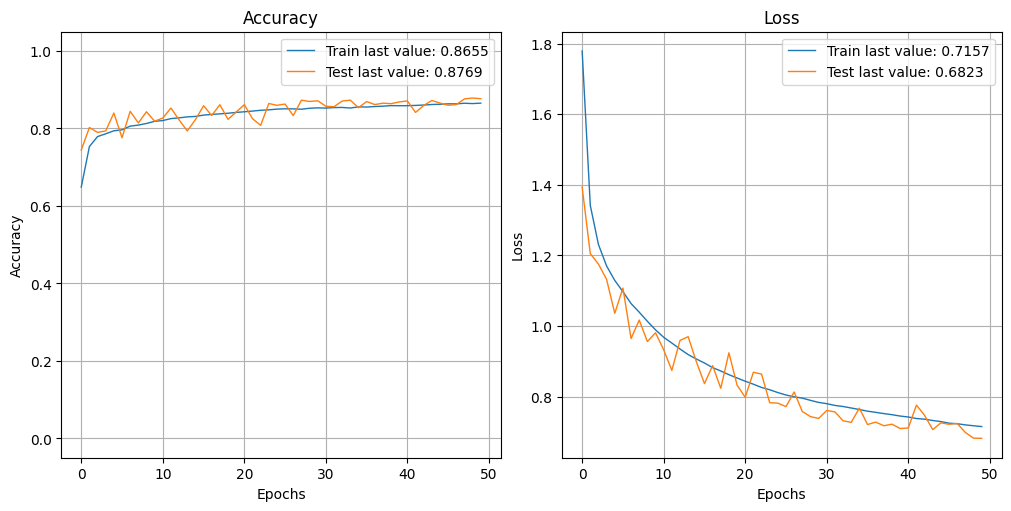

1875/1875 - 2s - 1ms/step - accuracy: 0.8727 - loss: 0.6946
Train accuracy: 87.27%
313/313 - 0s - 1ms/step - accuracy: 0.8769 - loss: 0.6823


2024/04/21 15:03:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 87.69%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Digit: 3


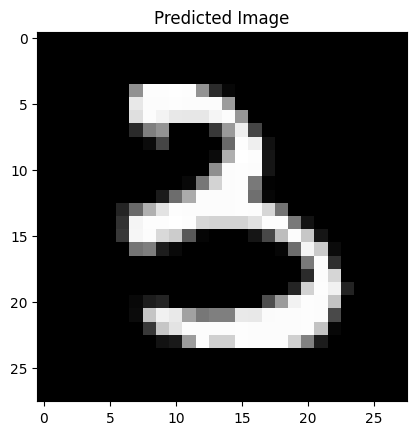

In [29]:
mlp_params = {
    "layer1_size": 256,
    "dropout_rate_l1": 0,
    "layer2_size": 128,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": regularizers.L2(0.01),
}

train_params = dict(
    use_optimiser=False,
    learning_rate=0.1,
    momentum=0.0, 
    num_epochs=50,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_regularized",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

____________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________

## Adding Dropout

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5516 - loss: 1.3252 - val_accuracy: 0.9112 - val_loss: 0.2999
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8660 - loss: 0.4626 - val_accuracy: 0.9269 - val_loss: 0.2495
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8877 - loss: 0.3961 - val_accuracy: 0.9346 - val_loss: 0.2168
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8996 - loss: 0.3554 - val_accuracy: 0.9419 - val_loss: 0.2017
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9116 - loss: 0.3228 - val_accuracy: 0.9465 - val_loss: 0.1850
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9142 - loss: 0.3157 - val_accuracy: 0.9503 - val_loss: 0.1736
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9205 - loss: 0.2860 - val_accuracy: 0.9525 - val_loss: 0.1680
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9262 - loss: 0.2839 - 

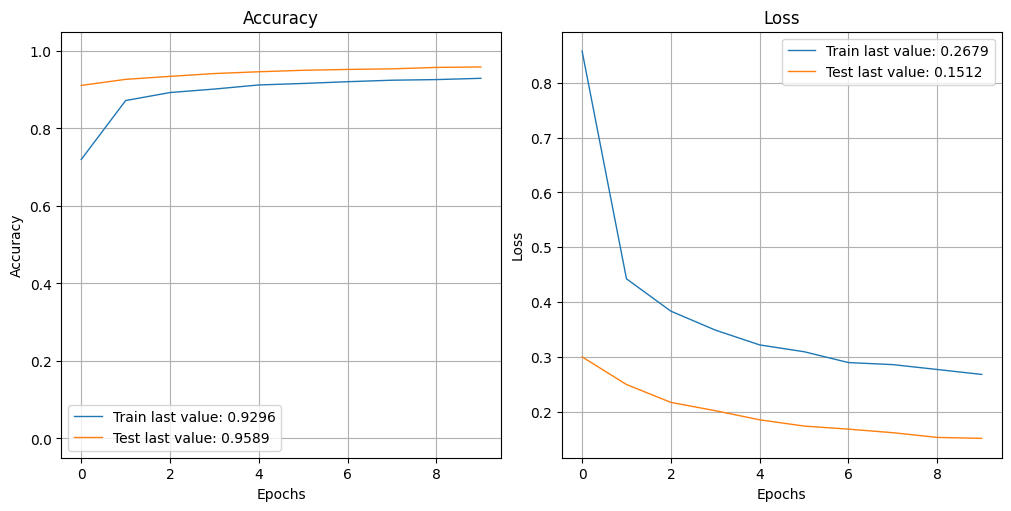

1875/1875 - 2s - 1ms/step - accuracy: 0.9610 - loss: 0.1421
Train accuracy: 96.10%
313/313 - 0s - 1ms/step - accuracy: 0.9589 - loss: 0.1512


2024/04/21 15:04:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 95.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Digit: 3


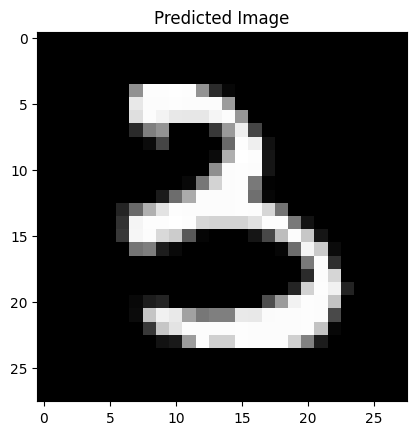

In [30]:
mlp_params = {
    "layer1_size": 256,
    "dropout_rate_l1": 0.7,
    "layer2_size": 128,
    "dropout_rate_l2": 0.6,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=False,
    learning_rate=0.1,
    momentum=0.0, 
    num_epochs=10,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_with_dropout",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

____________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________

## Adding Early Stopping Method

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7980 - loss: 0.7143 - val_accuracy: 0.9403 - val_loss: 0.2024
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9435 - loss: 0.1911 - val_accuracy: 0.9564 - val_loss: 0.1406
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9631 - loss: 0.1269 - val_accuracy: 0.9661 - val_loss: 0.1074
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9731 - loss: 0.0908 - val_accuracy: 0.9702 - val_loss: 0.0946
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9779 - loss: 0.0719 - val_accuracy: 0.9736 - val_loss: 0.0834
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9825 - loss: 0.0581 - val_accuracy: 0.9771 - val_loss: 0.0749
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9841 - loss: 0.0498 - val_accuracy: 0.9776 - val_loss: 0.0700
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9869 - loss: 0.0413 -

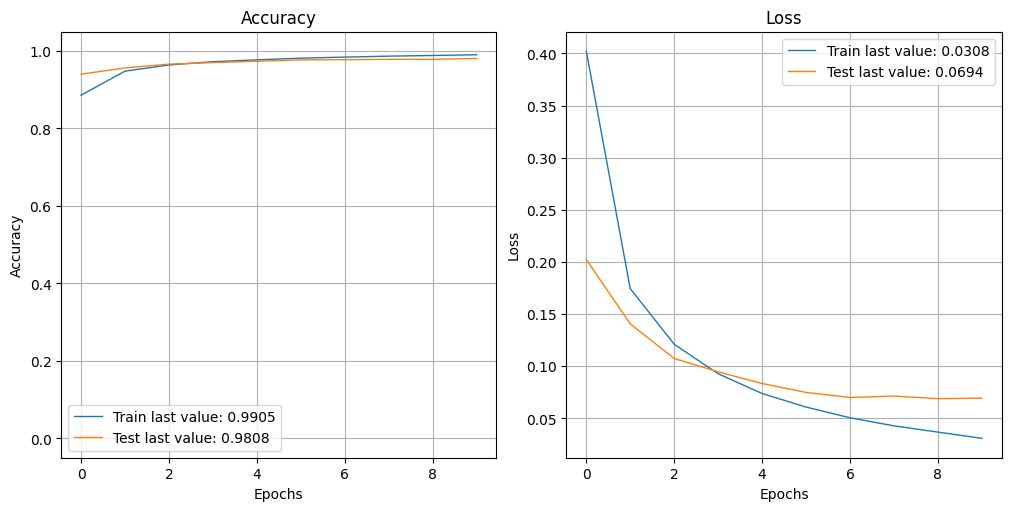

1875/1875 - 2s - 1ms/step - accuracy: 0.9954 - loss: 0.0156
Train accuracy: 99.54%
313/313 - 0s - 1ms/step - accuracy: 0.9786 - loss: 0.0785


2024/04/21 15:06:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 97.86%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Digit: 3


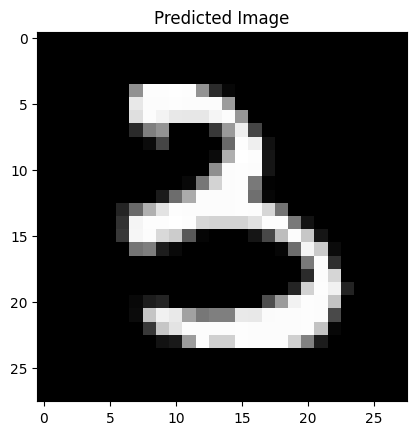

In [31]:
mlp_params = {
    "layer1_size": 256,
    "dropout_rate_l1": 0,
    "layer2_size": 128,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=False,
    learning_rate=0.1,
    momentum=0.0, 
    num_epochs=10,
    steps_per_epoch=50,
    early_stopping=True,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_with_earlt_stopping",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

____________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________

## Using Learning rates

### Low Learning Rate

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0889 - loss: 2.3968 - val_accuracy: 0.0892 - val_loss: 2.3984
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0905 - loss: 2.3970 - val_accuracy: 0.0892 - val_loss: 2.3969
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0902 - loss: 2.3933 - val_accuracy: 0.0892 - val_loss: 2.3954
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0895 - loss: 2.3932 - val_accuracy: 0.0892 - val_loss: 2.3939
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0899 - loss: 2.3925 - val_accuracy: 0.0892 - val_loss: 2.3924
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0919 - loss: 2.3892 - val_accuracy: 0.0892 - val_loss: 2.3910
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0923 - loss: 2.3875 - val_accuracy: 0.0892 - val_loss: 2.3895
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0897 - loss: 2.3897 - 

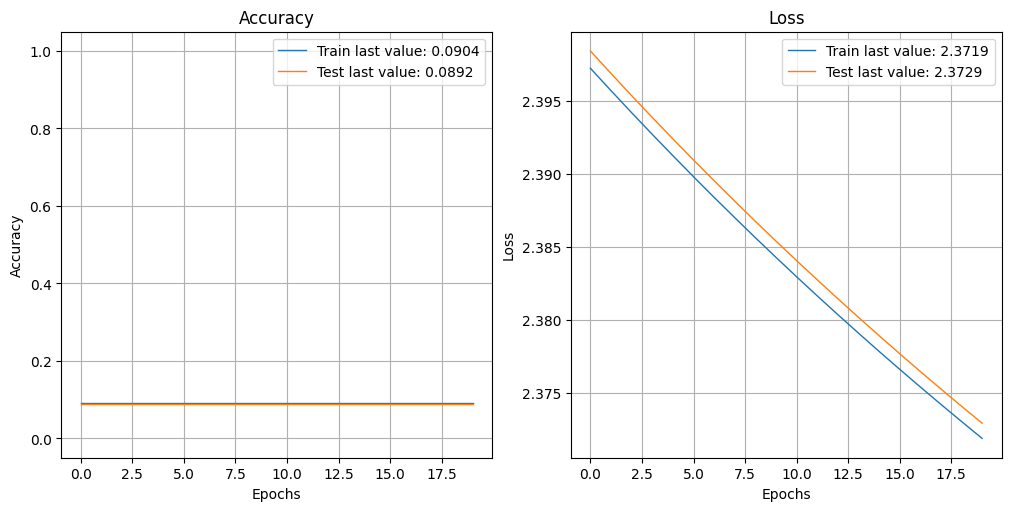

1875/1875 - 2s - 886us/step - accuracy: 0.0904 - loss: 2.3713
Train accuracy:  9.04%
313/313 - 0s - 1ms/step - accuracy: 0.0892 - loss: 2.3729


2024/04/21 15:07:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy:  8.92%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Digit: 5


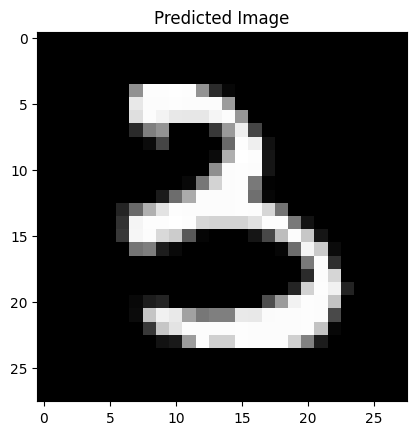

In [32]:
mlp_params = {
    "layer1_size": 20,
    "dropout_rate_l1": 0,
    "layer2_size": 10,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=True,
    learning_rate=0.00001,
    momentum=0.0,
    num_epochs=20,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_with_low_lwarning_rate",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

### High Learning Rate

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1030 - loss: 2.4798 - val_accuracy: 0.2723 - val_loss: 2.2875
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2952 - loss: 1.9968 - val_accuracy: 0.5050 - val_loss: 1.6964
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5998 - loss: 1.1876 - val_accuracy: 0.7949 - val_loss: 0.8179
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7350 - loss: 0.9317 - val_accuracy: 0.7825 - val_loss: 0.8481
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7895 - loss: 0.7892 - val_accuracy: 0.8490 - val_loss: 0.6490
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8081 - loss: 0.7310 - val_accuracy: 0.8371 - val_loss: 0.6742
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8049 - loss: 0.7258 - val_accuracy: 0.7760 - val_loss: 0.8358
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7965 - loss: 0.7627 - 

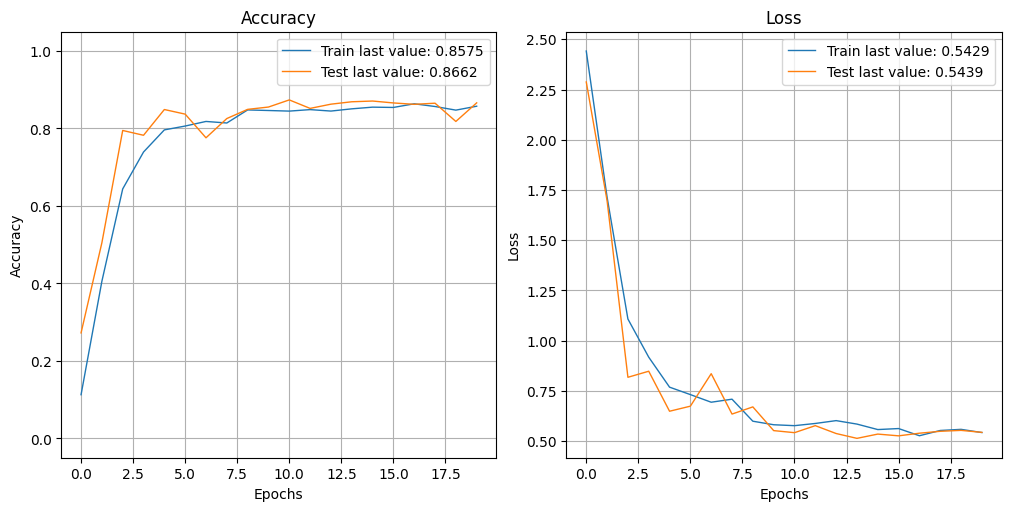

1875/1875 - 2s - 917us/step - accuracy: 0.8688 - loss: 0.5247
Train accuracy: 86.88%
313/313 - 0s - 990us/step - accuracy: 0.8662 - loss: 0.5439


2024/04/21 15:08:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 86.62%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Digit: 3


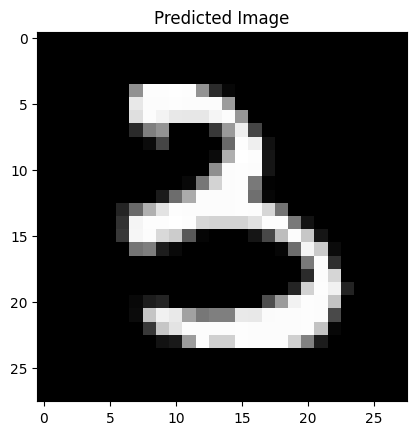

In [33]:
mlp_params = {
    "layer1_size": 20,
    "dropout_rate_l1": 0,
    "layer2_size": 10,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=True,
    learning_rate=10.0,
    momentum=0.0,
    num_epochs=20,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_with_high_learning_rate",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

### Optimal Learning Rate

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1600 - loss: 2.2960 - val_accuracy: 0.2891 - val_loss: 2.2247
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3469 - loss: 2.1886 - val_accuracy: 0.4581 - val_loss: 2.0279
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4718 - loss: 1.9457 - val_accuracy: 0.5887 - val_loss: 1.6791
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5945 - loss: 1.6035 - val_accuracy: 0.6682 - val_loss: 1.3738
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6915 - loss: 1.3165 - val_accuracy: 0.7499 - val_loss: 1.1331
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7632 - loss: 1.0893 - val_accuracy: 0.8004 - val_loss: 0.9534
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7981 - loss: 0.9329 - val_accuracy: 0.8300 - val_loss: 0.8223
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8226 - loss: 0.8098 - 

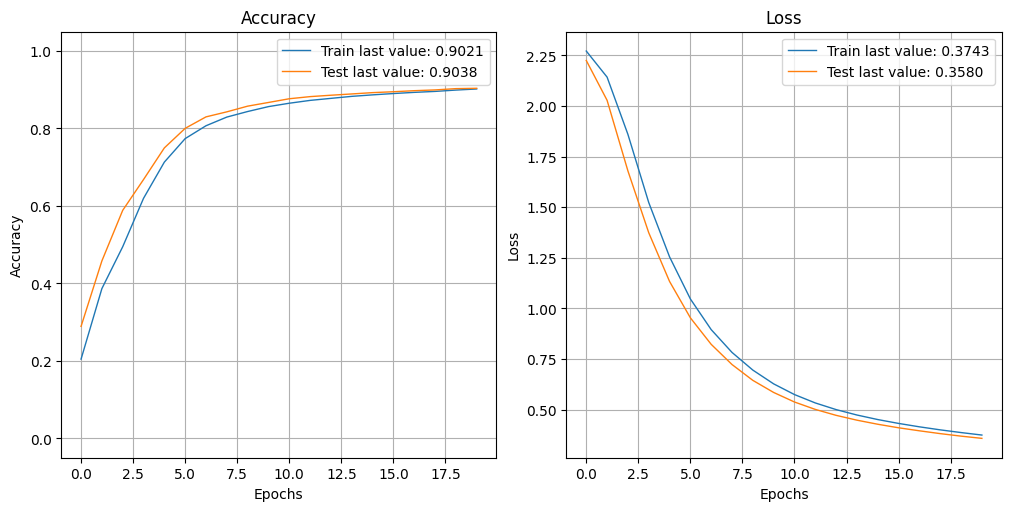

1875/1875 - 2s - 890us/step - accuracy: 0.9032 - loss: 0.3678
Train accuracy: 90.32%
313/313 - 0s - 965us/step - accuracy: 0.9038 - loss: 0.3580


2024/04/21 15:09:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 90.38%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Digit: 3


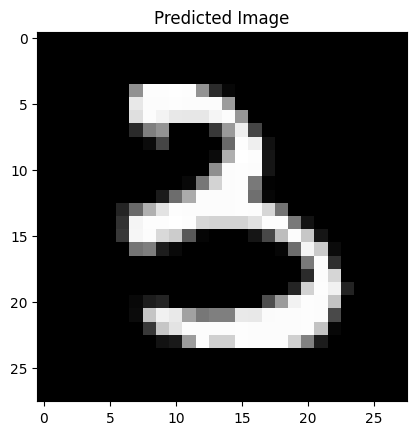

In [34]:
mlp_params = {
    "layer1_size": 20,
    "dropout_rate_l1": 0,
    "layer2_size": 10,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=True,
    learning_rate=0.01,
    momentum=0.0,
    num_epochs=20,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_with_optimal_learning_rate",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

### optimal learning rate with momentum

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2214 - loss: 2.2460 - val_accuracy: 0.4884 - val_loss: 1.8454
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5376 - loss: 1.6781 - val_accuracy: 0.6842 - val_loss: 1.2325
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7002 - loss: 1.1489 - val_accuracy: 0.7655 - val_loss: 0.9144
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7785 - loss: 0.8689 - val_accuracy: 0.8231 - val_loss: 0.7183
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8299 - loss: 0.6955 - val_accuracy: 0.8528 - val_loss: 0.5961
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8533 - loss: 0.5880 - val_accuracy: 0.8702 - val_loss: 0.5177
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8690 - loss: 0.5115 - val_accuracy: 0.8801 - val_loss: 0.4647
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8773 - loss: 0.4673 - 

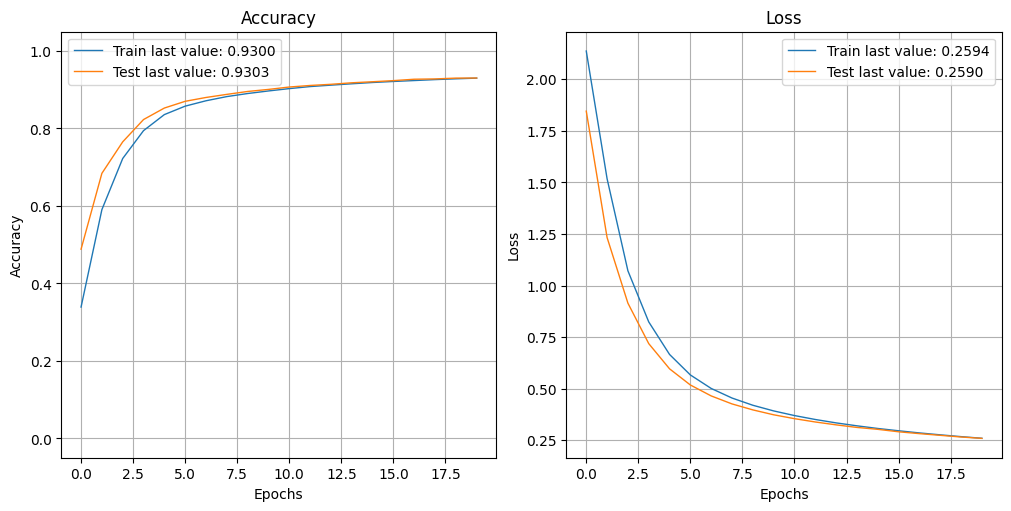

1875/1875 - 2s - 909us/step - accuracy: 0.9316 - loss: 0.2539
Train accuracy: 93.16%
313/313 - 0s - 853us/step - accuracy: 0.9303 - loss: 0.2590


2024/04/21 15:10:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 93.03%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Digit: 3


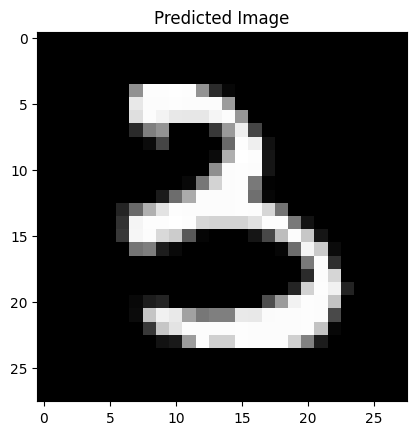

In [35]:
mlp_params = {
    "layer1_size": 20,
    "dropout_rate_l1": 0,
    "layer2_size": 10,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=True,
    learning_rate=0.01,
    momentum=0.5,
    num_epochs=20,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=32,
)

mlp_mlflow_run(
    "mlp_with_optimal_learning_rate_and_momentum",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)

____________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________

## Using Mini-batch SGD

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1116 - loss: 2.4220 - val_accuracy: 0.1135 - val_loss: 2.3118
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1140 - loss: 2.3029 - val_accuracy: 0.1151 - val_loss: 2.2844
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1156 - loss: 2.2814 - val_accuracy: 0.1244 - val_loss: 2.2723
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1232 - loss: 2.2707 - val_accuracy: 0.1334 - val_loss: 2.2618
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1436 - loss: 2.2598 - val_accuracy: 0.1810 - val_loss: 2.2505
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1956 - loss: 2.2486 - val_accuracy: 0.2233 - val_loss: 2.2380
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2321 - loss: 2.2359 - val_accuracy: 0.2488 - val_loss: 2.2239
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2551 - loss: 2.2216 - val_accuracy: 0.

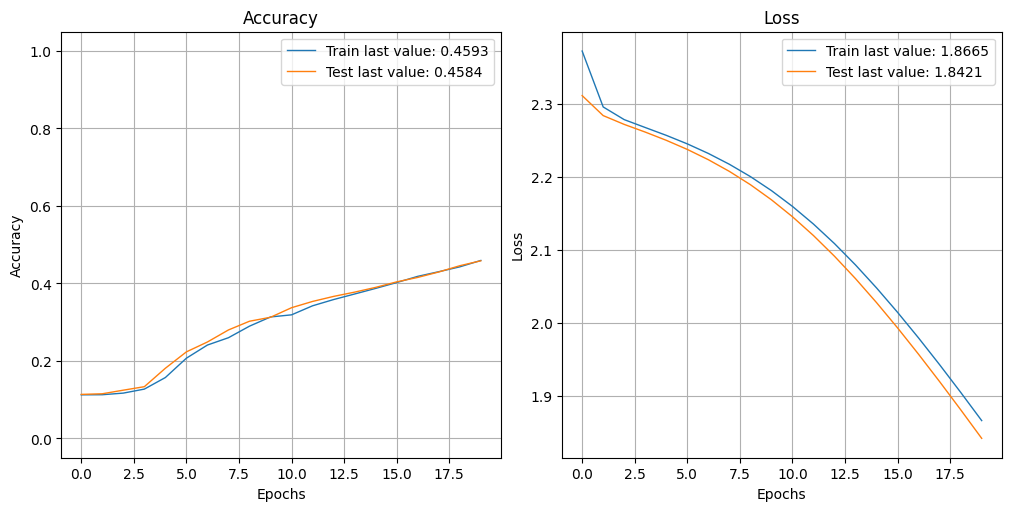

1875/1875 - 2s - 849us/step - accuracy: 0.4642 - loss: 1.8465
Train accuracy: 46.42%
313/313 - 0s - 872us/step - accuracy: 0.4584 - loss: 1.8421


2024/04/21 15:10:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Test accuracy: 45.84%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Digit: 3


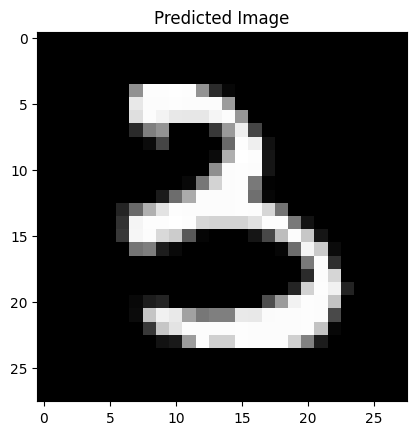

In [36]:
mlp_params = {
    "layer1_size": 20,
    "dropout_rate_l1": 0,
    "layer2_size": 10,
    "dropout_rate_l2": 0,
    "output_size": 10,
    "activation": 'sigmoid',
    "regularizers": None,
}

train_params = dict(
    use_optimiser=True,
    learning_rate=0.01,
    momentum=0.5,
    num_epochs=20,
    steps_per_epoch=50,
    early_stopping=False,
    batch_size=512,
)

mlp_mlflow_run(
    "mlp_with_mini_batch_and_momentum",
    mlp_params,
    train_params,
    x_train, 
    y_train,
    x_test,
    y_test,
)